In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import scipy.spatial.distance
from scipy.special import erf
import math


In [2]:
# Class to apply Kalman filter
class KalmanFilters:
    def apply_kalman_filter(self, data_table, col):
        kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])
        numpy_array_state = data_table[col].values
        numpy_array_state = numpy_array_state.astype(np.float32)
        numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)
        kf = kf.em(numpy_matrix_state_with_mask, n_iter=10)
        (new_data, filtered_state_covariances) = kf.filter(numpy_matrix_state_with_mask)
        data_table[col + '_kalman'] = new_data
        return data_table

# Utility function to normalize dataset
def normalize_dataset(data, cols):
    for col in cols:
        data[col] = (data[col] - data[col].mean()) / data[col].std()
    return data

# Function to detect outliers using Local Outlier Factor (LOF)
def detect_outliers_lof(data_table, cols, d_function='euclidean', k=5):
    new_data_table = normalize_dataset(data_table.dropna(axis=0, subset=cols), cols)
    lof = LocalOutlierFactor(n_neighbors=k, metric=d_function)
    outlier_counts = {}
    for col in cols:
        df_col = new_data_table[col].values.reshape(-1, 1)
        outlier_flags = lof.fit_predict(df_col)
        outlier_counts[col] = np.sum(outlier_flags == -1)
        data_table[col + '_lof'] = np.where(outlier_flags == -1, np.nan, data_table[col])
    return data_table, outlier_counts

# Load the dataset
def load_data(filename):
    return pd.read_csv(filename)

# Function to calculate changes
def calculate_changes(data, original_col, filtered_col):
    diff = data[filtered_col].isna() | (np.abs(data[original_col] - data[filtered_col]) > 0)
    num_changes = diff.sum()
    perc_changes = (num_changes / len(data) * 100).round(2)
    return num_changes, perc_changes


In [6]:
# Function to apply Kalman filter and compare
def apply_kalman_and_compare(data, cols):
    kf_instance = KalmanFilters()
    summary_results = []

    for col in cols:
        # Apply Kalman filter
        data = kf_instance.apply_kalman_filter(data, col)
        num_changes_kalman, perc_changes_kalman = calculate_changes(data, col, col + '_kalman')

        summary_results.append({
            'Sensor Type': col,
            'Kalman_Num_Changes': num_changes_kalman,
            'Kalman_Perc_Changes': perc_changes_kalman,
        })

        # Plot original vs Kalman filtered data
        plt.figure(figsize=(10, 6))
        plt.plot(data['time'], data[col], label='Original', linewidth=1)
        plt.plot(data['time'], data[col + '_kalman'], label='Kalman Filtered', color='orange', linewidth=1)
        plt.title(f'{col} - Original vs Kalman Filtered')
                  #\nOutliers Identified: {num_changes_kalman}')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

    return pd.DataFrame(summary_results)

# Function to apply LOF and compare
def apply_lof_and_compare(data, cols):
    summary_results = []

    # Apply LOF
    data, outlier_counts = detect_outliers_lof(data, cols)
    for col in cols:
        num_changes_lof, perc_changes_lof = calculate_changes(data, col, col + '_lof')

        summary_results.append({
            'Sensor Type': col,
            'LOF_Num_Changes': num_changes_lof,
            'LOF_Perc_Changes': perc_changes_lof,
            'LOF_Outliers': outlier_counts[col]
        })

        # Plot original vs LOF data
        plt.figure(figsize=(10, 6))
        plt.plot(data['time'], data[col], label='Original', linewidth=1)
        plt.scatter(data['time'], data[col + '_lof'], label='LOF Filtered', color='orange', s=10)
        plt.title(f'{col} - Original vs LOF Filtered\nOutliers Identified: {outlier_counts[col]}')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

    return pd.DataFrame(summary_results)


In [7]:
# Define the sensor files and columns
sensor_files = {
    'accelerometer': 'Combined_Accelerometer_0.5s.csv',
    'gyroscope': 'Combined_Gyroscope_0.5s.csv',
    'linear_accelerometer': 'Combined_Linear Accelerometer_0.5s.csv',
    'magnetometer': 'Combined_Magnetometer_0.5s.csv'
}

sensor_columns = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Define the base path
base_path = '/Users/priyank/Desktop/ML4QS-project/All DATA'


Initial statistics for accelerometer from Combined_Accelerometer_0.5s.csv:
         X (m/s^2)    Y (m/s^2)    Z (m/s^2)
count  2407.000000  2407.000000  2407.000000
mean      2.567880     3.173132     1.061711
std       4.709899     5.541561     3.003028
min     -19.577039   -17.996350   -18.353783
25%      -0.925681    -0.868904    -0.586374
50%       2.088478     4.463988     0.831162
75%       5.908175     8.084709     2.562200
max      30.706994    12.205570    14.397361


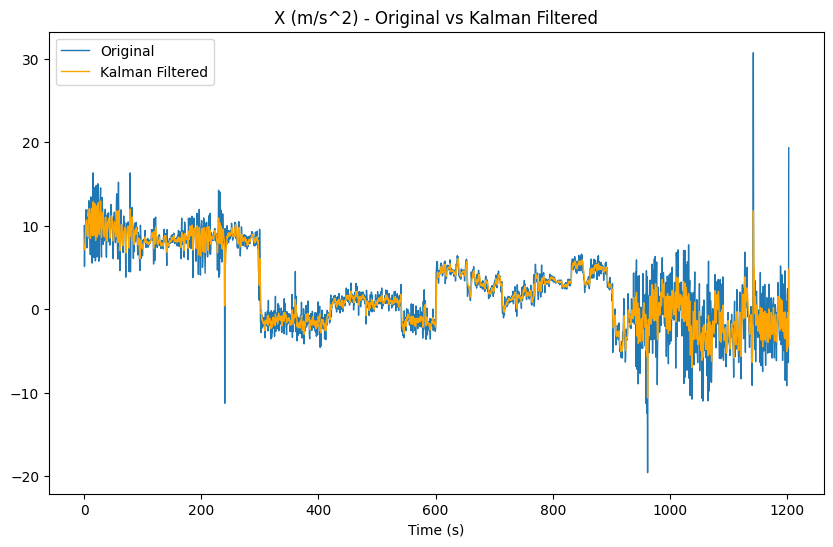

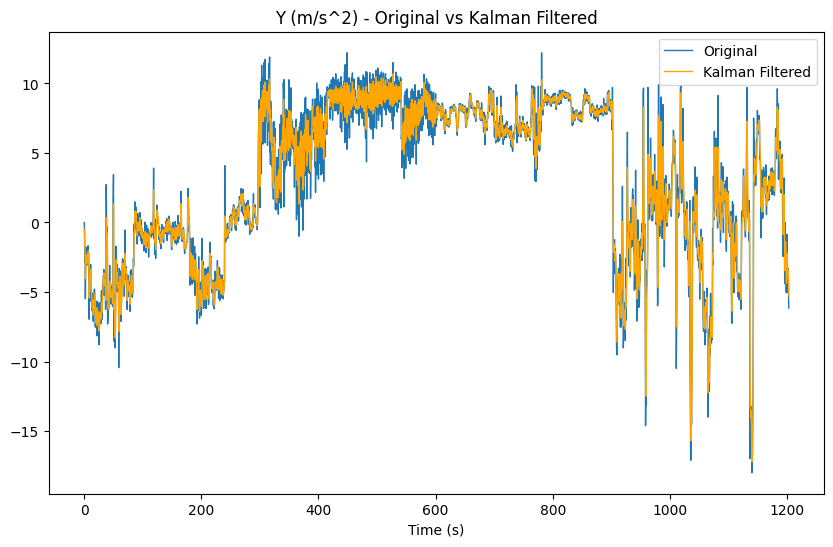

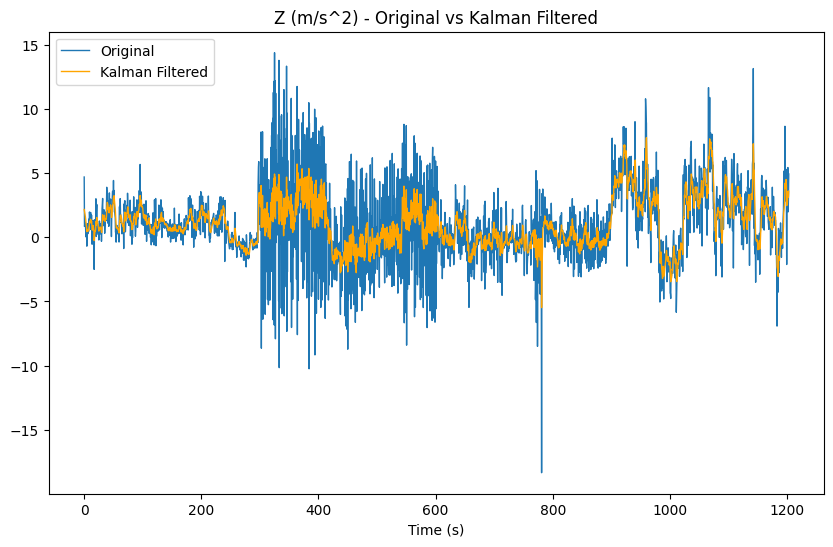

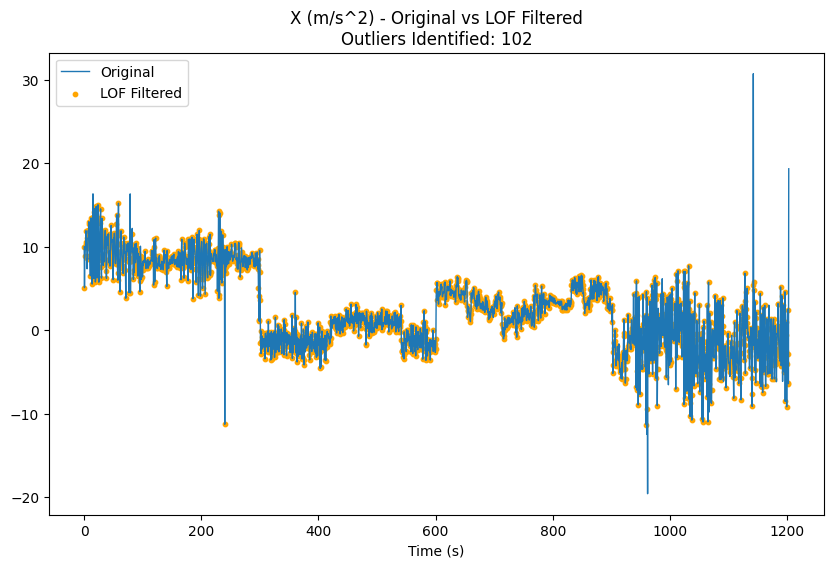

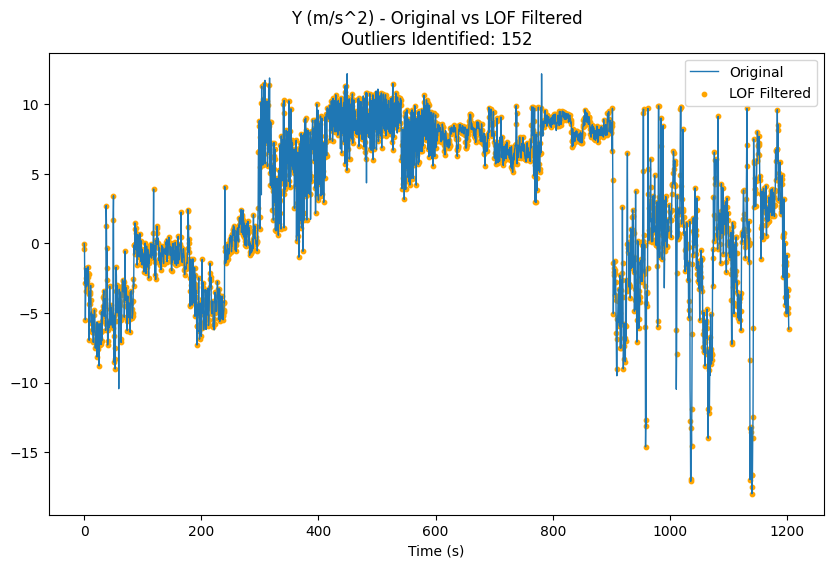

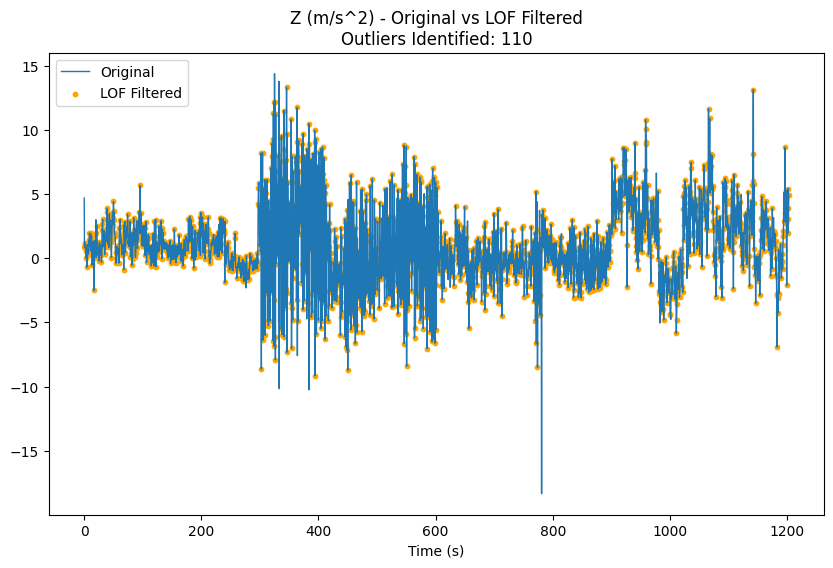

Initial statistics for gyroscope from Combined_Gyroscope_0.5s.csv:
         X (rad/s)    Y (rad/s)    Z (rad/s)
count  2401.000000  2401.000000  2401.000000
mean      0.109735    -0.042719     0.014096
std       0.615644     0.430618     0.648423
min      -3.141844    -4.650992    -3.626656
25%      -0.146220    -0.207066    -0.171425
50%       0.102072    -0.037759     0.002014
75%       0.377858     0.129919     0.183200
max       2.687985     3.549800     8.012442


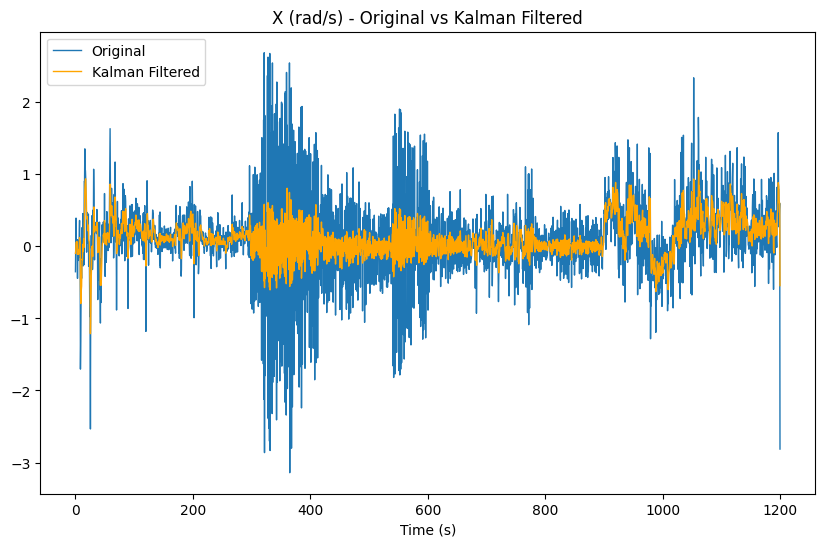

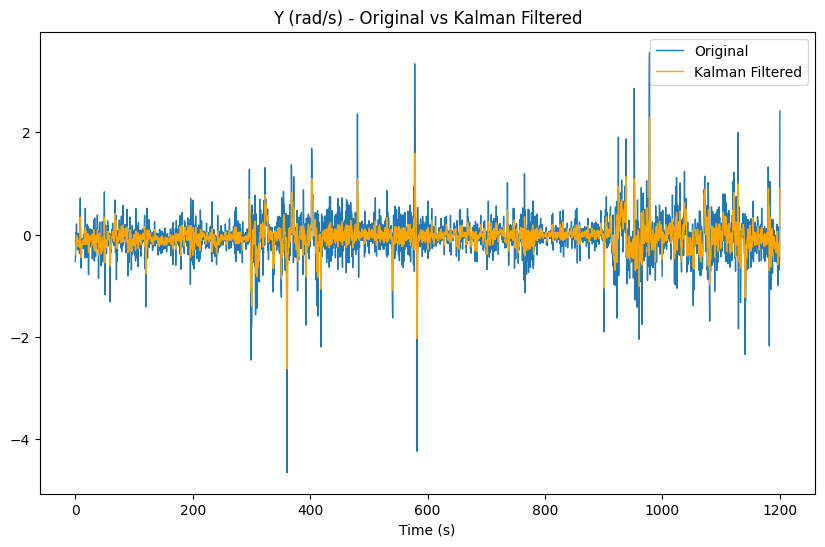

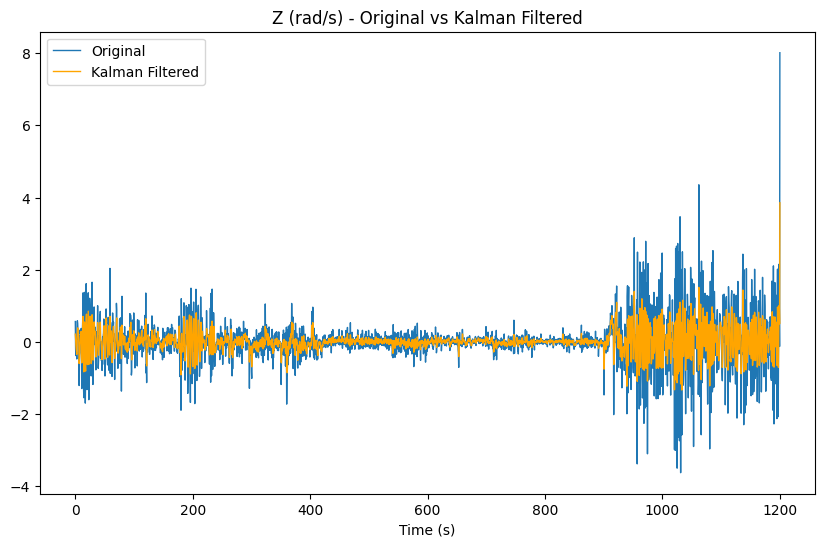

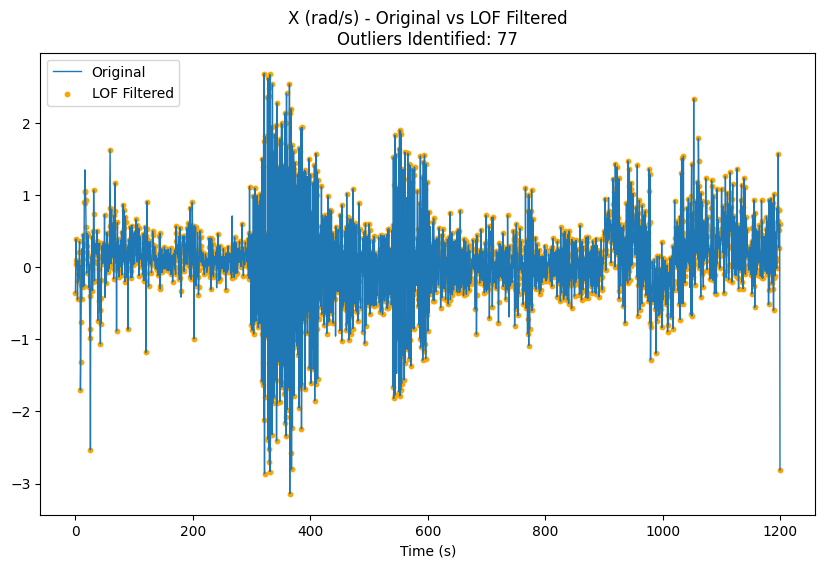

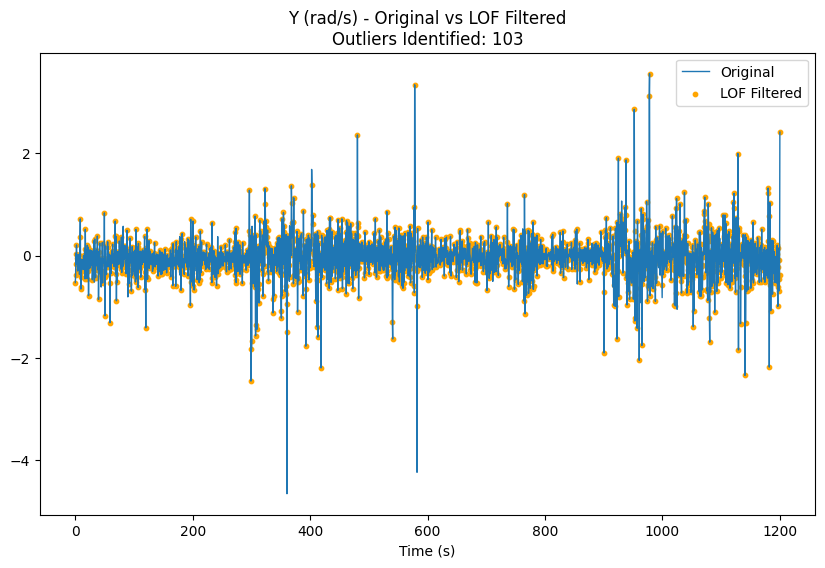

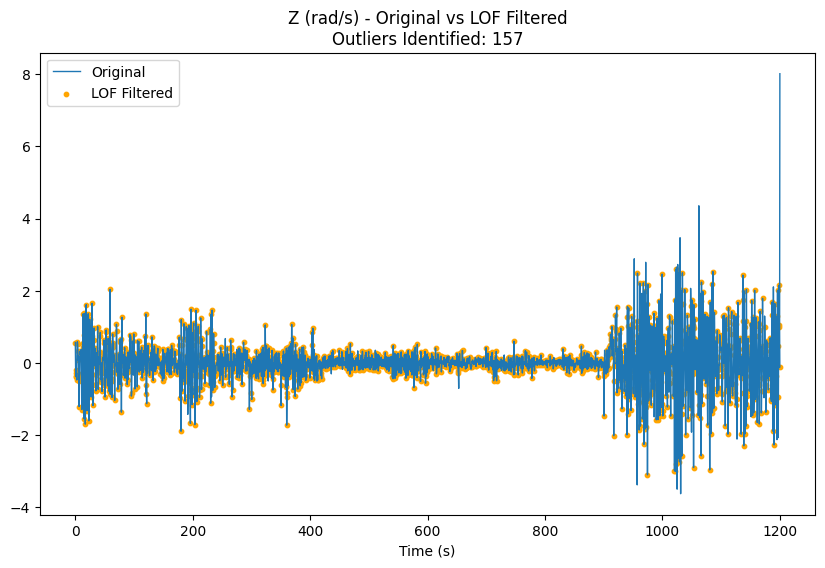

Initial statistics for linear_accelerometer from Combined_Linear Accelerometer_0.5s.csv:
         X (m/s^2)    Y (m/s^2)    Z (m/s^2)
count  2401.000000  2401.000000  2401.000000
mean      0.287166    -3.967654     0.164523
std       1.627007     3.834229     1.788728
min      -7.813898   -22.455791    -8.747693
25%      -0.456293    -6.032332    -0.707211
50%       0.155342    -3.167955     0.093827
75%       0.938884    -0.782814     0.974442
max      17.883820     2.658775     8.340778


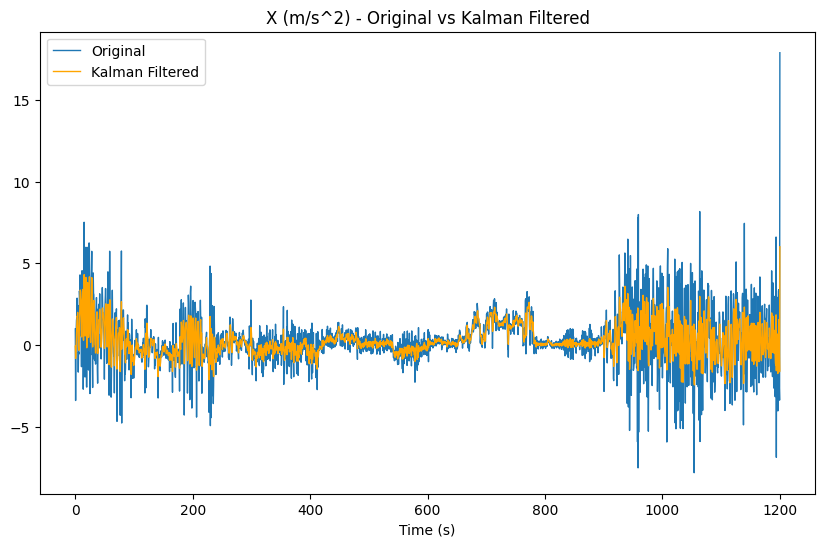

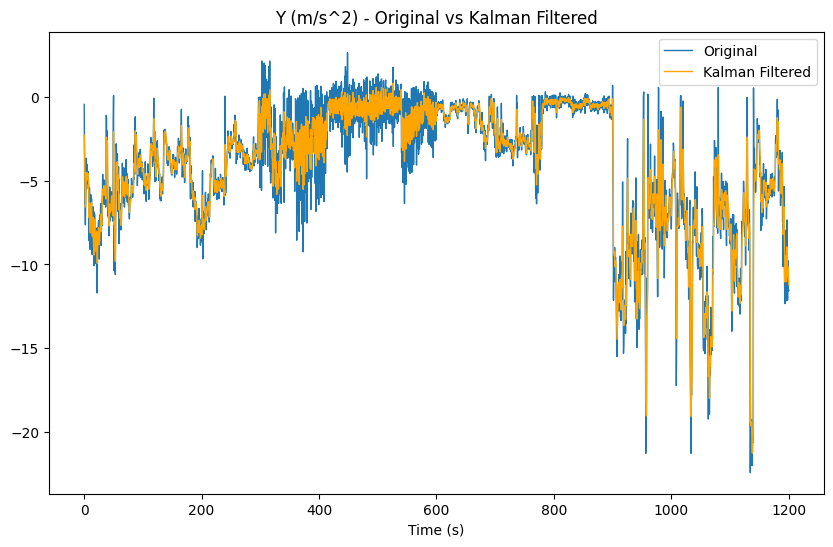

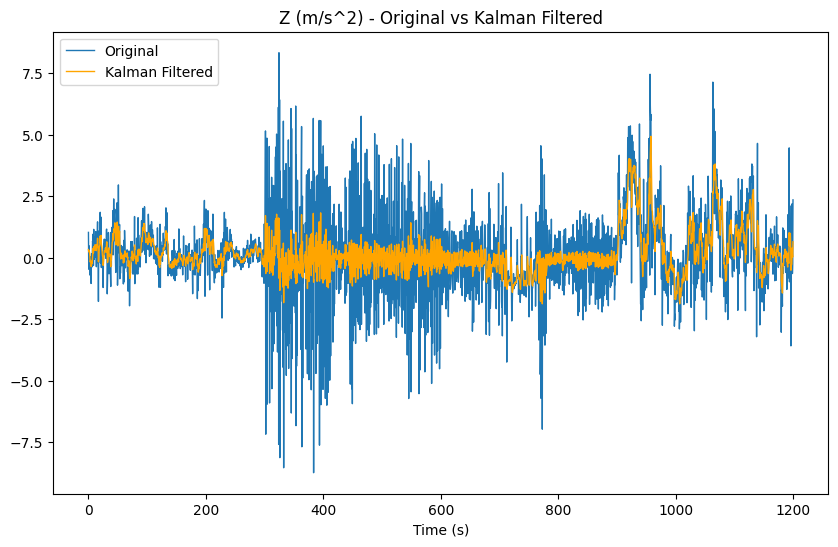

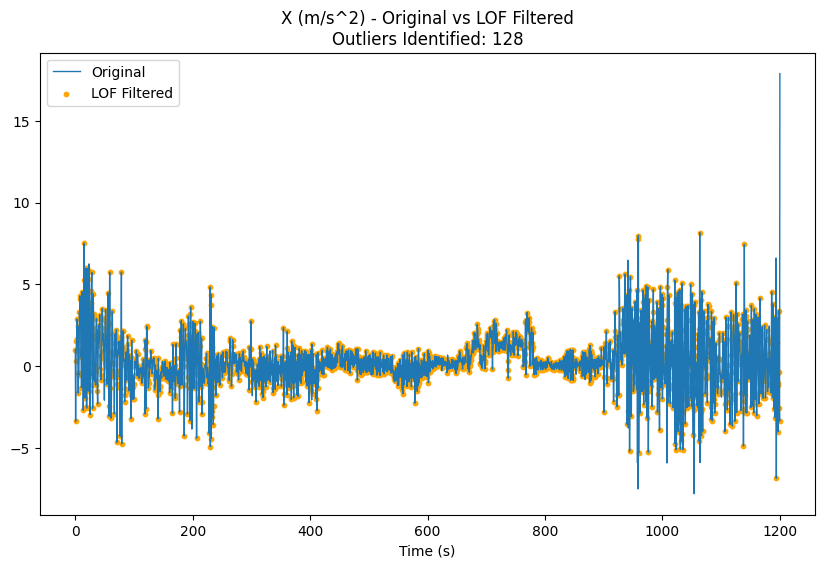

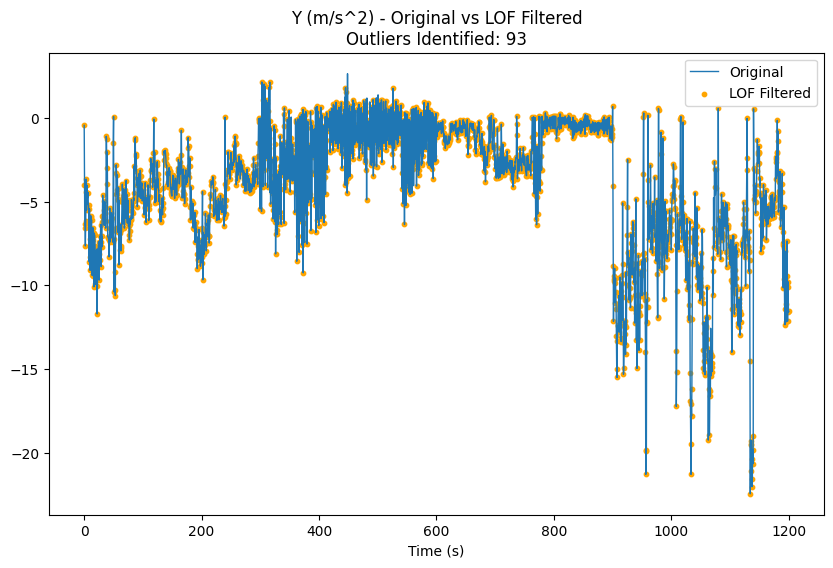

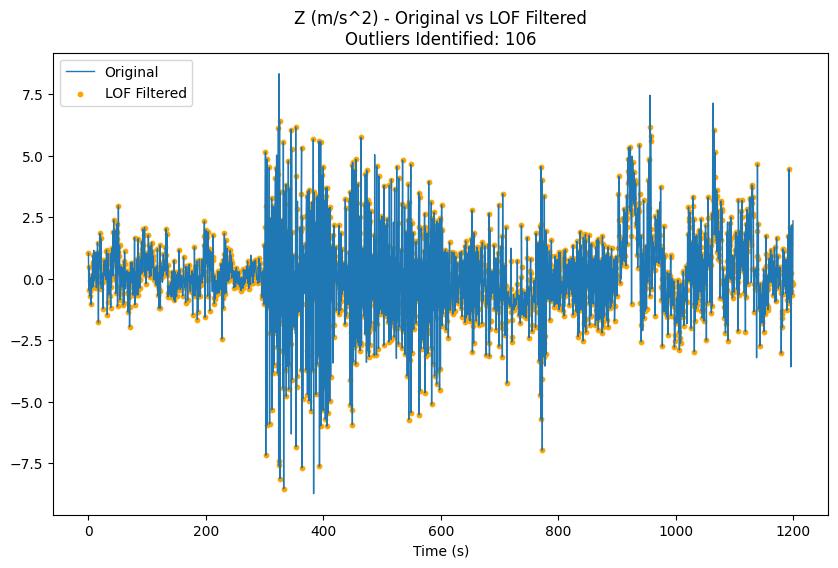

Initial statistics for magnetometer from Combined_Magnetometer_0.5s.csv:
            X (µT)       Y (µT)       Z (µT)
count  2401.000000  2401.000000  2401.000000
mean     11.460107   -65.882758    28.755851
std      61.770477   179.124937   121.585595
min     -86.480186  -929.477409   -47.807681
25%     -17.531336   -33.849465   -10.560286
50%       8.519476   -30.801567     3.791282
75%      19.327916   -25.712889    15.068884
max     296.461110    40.196921   629.044740


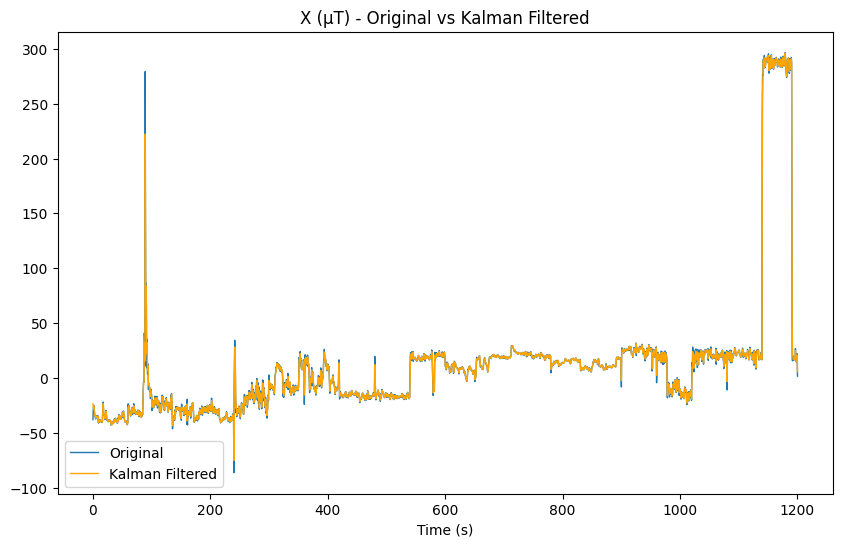

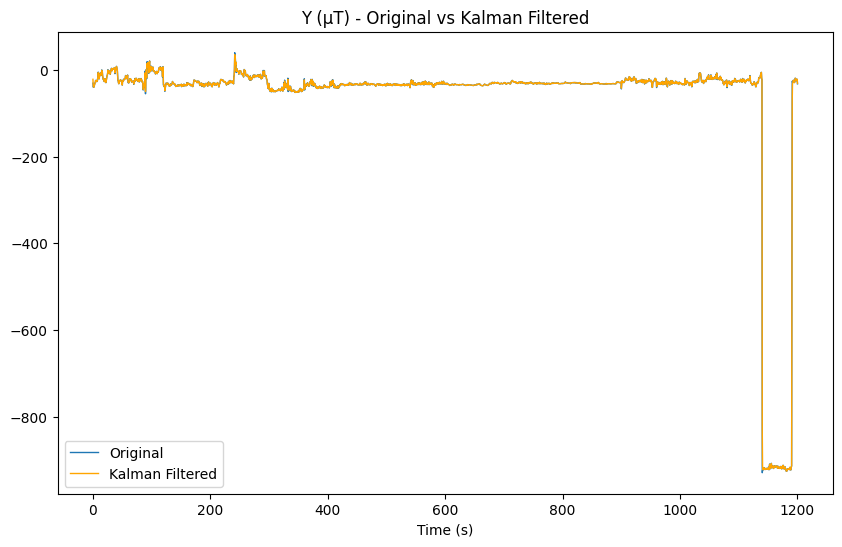

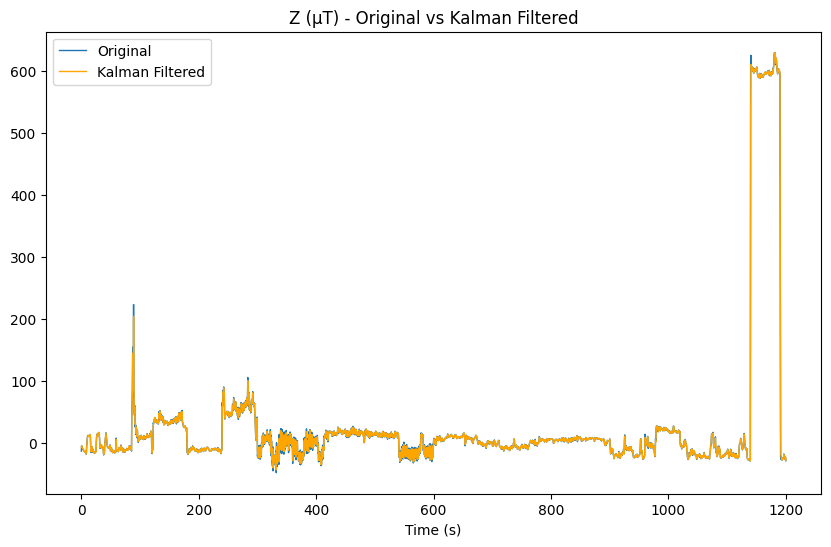

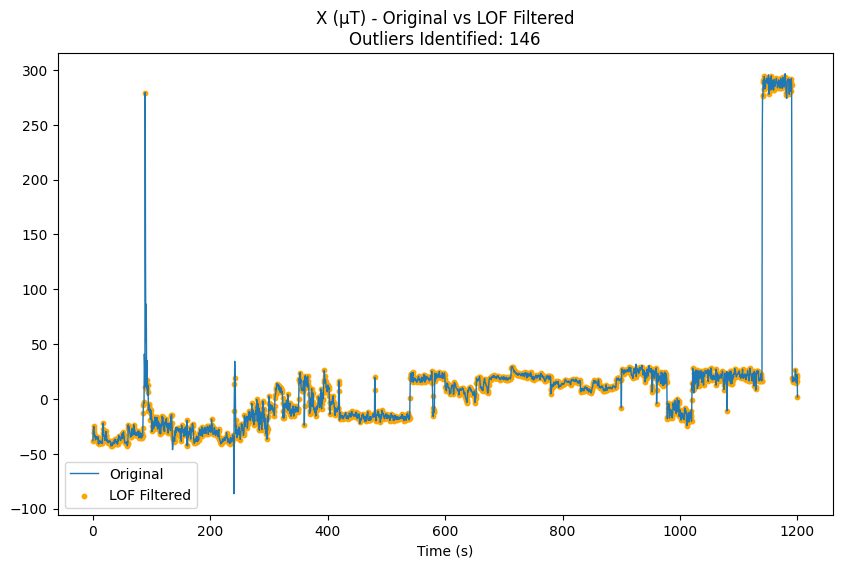

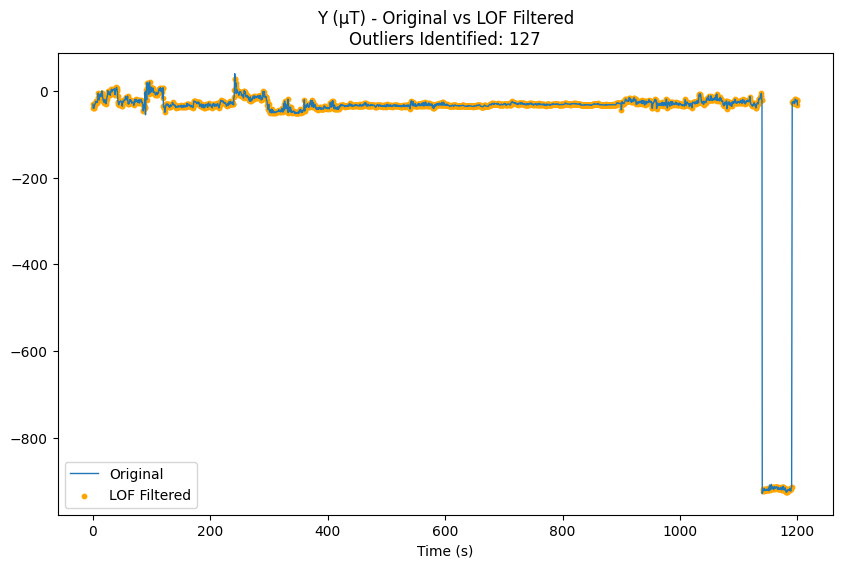

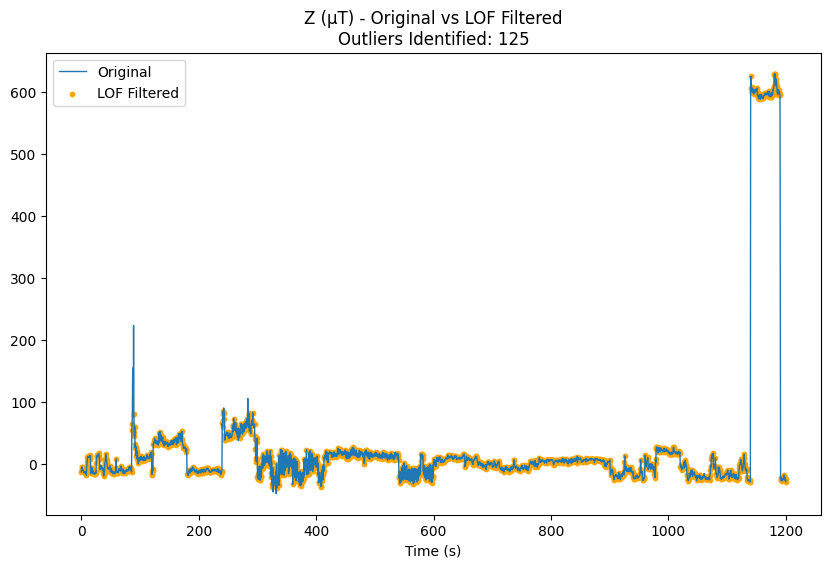

In [8]:
# Perform comparison on each combined file
kalman_summary_all = []
lof_summary_all = []

for sensor_type, filename in sensor_files.items():
    cols = sensor_columns[sensor_type]
    data = load_data(os.path.join(base_path, filename))
    
    # Initial data statistics
    print(f"Initial statistics for {sensor_type} from {filename}:")
    print(data[cols].describe())
    
    # Apply Kalman filter and compare
    kalman_summary = apply_kalman_and_compare(data.copy(), cols)
    kalman_summary['File'] = filename
    kalman_summary_all.append(kalman_summary)
    
    # Apply LOF and compare
    lof_summary = apply_lof_and_compare(data.copy(), cols)
    lof_summary['File'] = filename
    lof_summary_all.append(lof_summary)

# Concatenate all summaries
final_kalman_summary = pd.concat(kalman_summary_all, ignore_index=True)
final_lof_summary = pd.concat(lof_summary_all, ignore_index=True)

# Save the summaries to CSV files
final_kalman_summary.to_csv(os.path.join(base_path, 'kalman_filter_comparison_summary.csv'), index=False)
final_lof_summary.to_csv(os.path.join(base_path, 'lof_filter_comparison_summary.csv'), index=False)